In [1]:
import os
import yfinance as yf
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
import datetime
from datetime import date

In [223]:
ticker = 'CSSPX.MI'
start = "2019-01-01"
start1 = '2022-06-01'
today = date.today().strftime("%Y-%m-%d")

In [224]:
data = yf.download(ticker, start, today) # CSSPX.MI S&P500

[*********************100%***********************]  1 of 1 completed


In [225]:
df = data[['Adj Close']]
df = df.reset_index()

In [226]:
df1 = yf.download(ticker, start1, today)

df1.describe()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
count,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000
mean,394.849101,397.047158,392.652194,393.939999,393.939999,10684.654676
std,15.245788,14.944059,15.488206,15.831362,15.831362,6230.655087
min,360.299988,361.779999,357.140015,359.299988,359.299988,0.000000
25%,384.732491,387.022499,382.737511,380.549988,380.549988,6260.000000
50%,393.274994,395.350006,391.169998,392.774994,392.774994,9370.000000
75%,402.940010,404.675011,400.554993,403.302490,403.302490,13970.750000
max,435.500000,436.420013,433.019989,435.000000,435.000000,36886.000000


Text(0, 0.5, 'Adj Close')

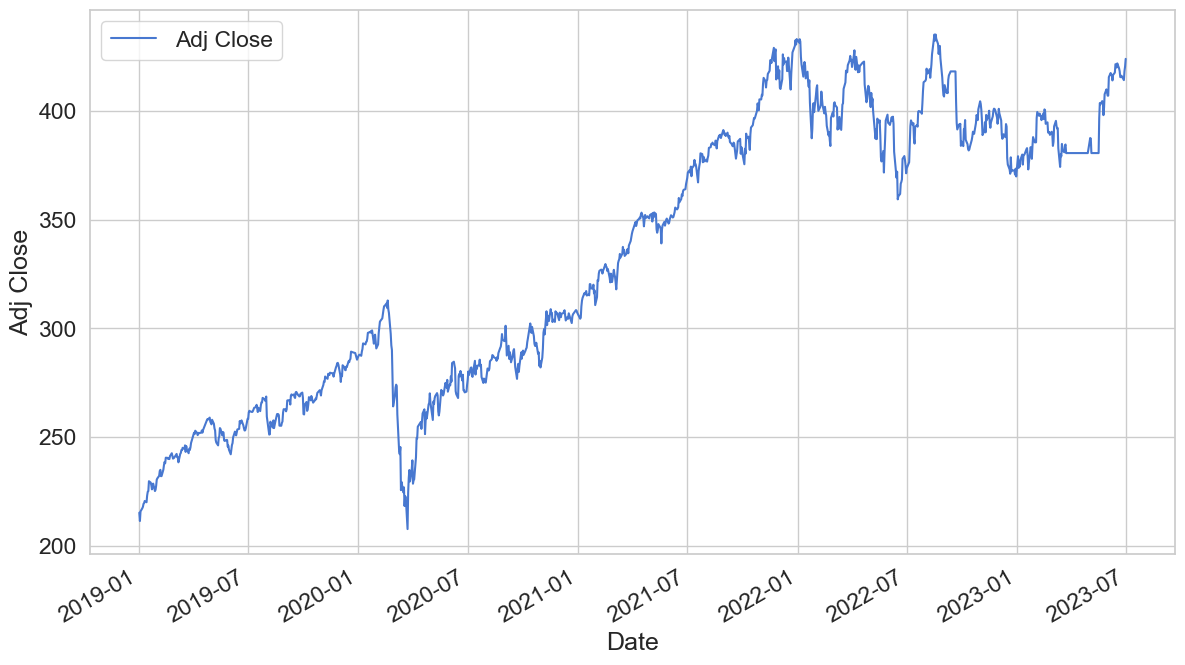

In [227]:
ax = df.plot(x='Date', y='Adj Close')
ax.set_xlabel('Date')
ax.set_ylabel('Adj Close')

In [228]:
df = df.rename(columns = {'Date' : 'Date', 'Adj Close' : 'Close'})
scaler = MinMaxScaler()
close_price = df.Close.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)
scaled_close = scaled_close[~np.isnan(scaled_close)]
scaled_close = scaled_close.reshape(-1, 1)

In [229]:
SEQ_LEN = 100
def to_sequences(data, seq_len):
    d = []
    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])
    return np.array(d)
def preprocess(data_raw, seq_len, train_split):
    data = to_sequences(data_raw, seq_len)
    num_train = int(train_split * data.shape[0])
    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]
    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]
    return X_train, y_train, X_test, y_test
X_train, y_train, X_test, y_test =\
 preprocess(scaled_close, SEQ_LEN, train_split = 0.80)

In [230]:
model = tf.keras.Sequential()
model.add(layers.LSTM(units=64, return_sequences=True,
 input_shape=(99,1), dropout=0.1))
model.add(layers.LSTM(units=32, return_sequences=True,
 dropout=0.1))
model.add(layers.LSTM(units=32, dropout=0.1))
model.add(layers.Dense(units=1))
model.summary()
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_57 (LSTM)              (None, 99, 64)            16896     
                                                                 
 lstm_58 (LSTM)              (None, 99, 32)            12416     
                                                                 
 lstm_59 (LSTM)              (None, 32)                8320      
                                                                 
 dense_19 (Dense)            (None, 1)                 33        
                                                                 
Total params: 37,665
Trainable params: 37,665
Non-trainable params: 0
_________________________________________________________________


In [231]:
BATCH_SIZE = 128
history = model.fit(
 X_train, 
 y_train, 
 epochs=5, 
 batch_size=BATCH_SIZE, 
 shuffle=False,
 validation_split=0.1
)
model.evaluate(X_test, y_test)

Epoch 1/5
6/6 [==============================] - 9s 523ms/step - loss: 0.0876 - val_loss: 0.0203
Epoch 2/5
6/6 [==============================] - 1s 183ms/step - loss: 0.0240 - val_loss: 0.0064
Epoch 3/5
6/6 [==============================] - 1s 179ms/step - loss: 0.0260 - val_loss: 0.0436
Epoch 4/5
6/6 [==============================] - 1s 184ms/step - loss: 0.0100 - val_loss: 0.0091
Epoch 5/5
7/7 [==============================] - 0s 33ms/step - loss: 0.0033


0.0032979799434542656

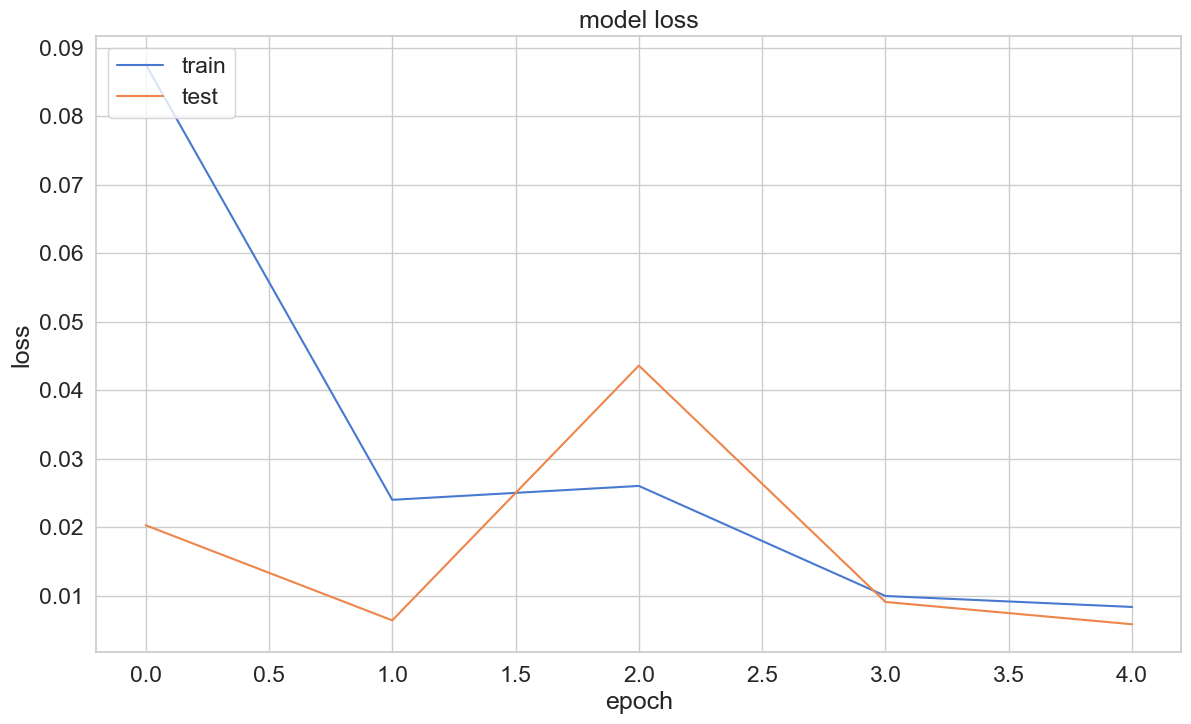

In [232]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

7/7 [==============================] - 1s 33ms/step


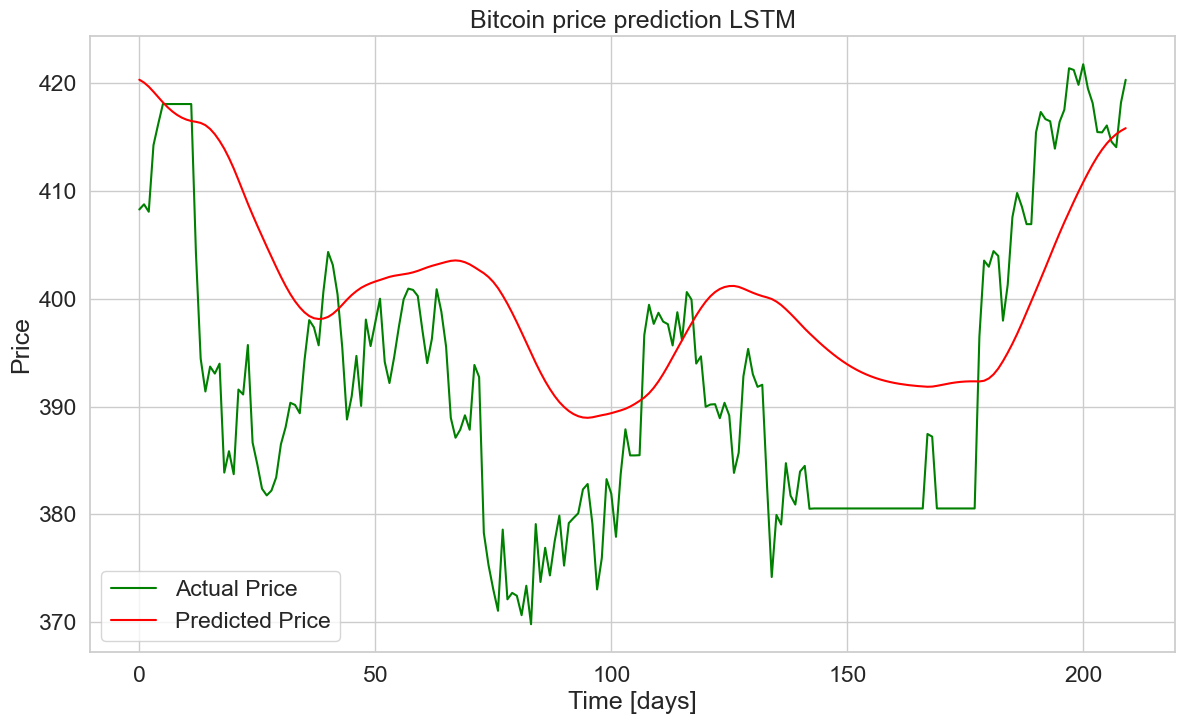

In [233]:
y_hat = model.predict(X_test)
y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label='Actual Price', color='green')
plt.plot(y_hat_inverse, label='Predicted Price', color='red')
 
plt.title('Bitcoin price prediction LSTM')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();

In [234]:
y_hat_inverse

array([[420.31604],
       [420.0501 ],
       [419.67142],
       [419.20374],
       [418.70377],
       [418.2122 ],
       [417.76312],
       [417.3737 ],
       [417.0519 ],
       [416.7991 ],
       [416.61206],
       [416.4848 ],
       [416.40976],
       [416.3072 ],
       [416.10086],
       [415.75055],
       [415.26068],
       [414.6405 ],
       [413.91516],
       [413.05685],
       [412.08795],
       [411.02066],
       [409.92078],
       [408.8237 ],
       [407.78284],
       [406.777  ],
       [405.79807],
       [404.83408],
       [403.8818 ],
       [402.94696],
       [402.04315],
       [401.19672],
       [400.4289 ],
       [399.76157],
       [399.2001 ],
       [398.73895],
       [398.39767],
       [398.1948 ],
       [398.12363],
       [398.16214],
       [398.31735],
       [398.59674],
       [398.98233],
       [399.43945],
       [399.91547],
       [400.34445],
       [400.70795],
       [401.01535],
       [401.24506],
       [401.43875],
